#**RNN Yöntemi ile Havayolu Yolcu Sayısı Tahmini**

In [198]:
# DataSet : https://www.kaggle.com/datasets/andreazzini/international-airline-passengers?resource=download

## Gerekli Kütüphaneleri İmport Ediyoruz

In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import Dense, SimpleRNN , Dropout
from keras.callbacks import EarlyStopping , ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

#Tensorflow Warninglerini Engellemek için gerekli kütüphaneler
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Veri Setini Yükleme ve İnceleme

In [200]:
df = pd.read_csv("international-airline-passengers.csv")
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [201]:
# 2.sütünun ismini değiştirdik.
df.columns = ["Month" , "Passengers"]
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [202]:
df.shape

(145, 2)

In [203]:
df.dtypes

,0
Month,object
Passengers,float64


In [204]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [205]:
df.isnull().sum() # 1 Tane Boş gözlemimiz var

,0
Month,0
Passengers,1


## Veriyi Hazırlama

In [206]:
df = df.dropna() # eksik değerden kurtulduk

In [207]:
df.shape

(144, 2)

In [208]:
df["Month"] = pd.to_datetime(df["Month"]) # Month değişkenini Objecten kurtardık

In [209]:
df.dtypes

,0
Month,datetime64[ns]
Passengers,float64


In [210]:
# Month değişkenini İndex kısmına atadık
df.index = df["Month"]
df.drop("Month",axis = 1,inplace = True)

In [211]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [212]:
result_df = df.copy() # Datamızın bir kopyasını aldık

<Axes: title={'center': 'Aylık Yolcu Sayısı'}, xlabel='Month'>

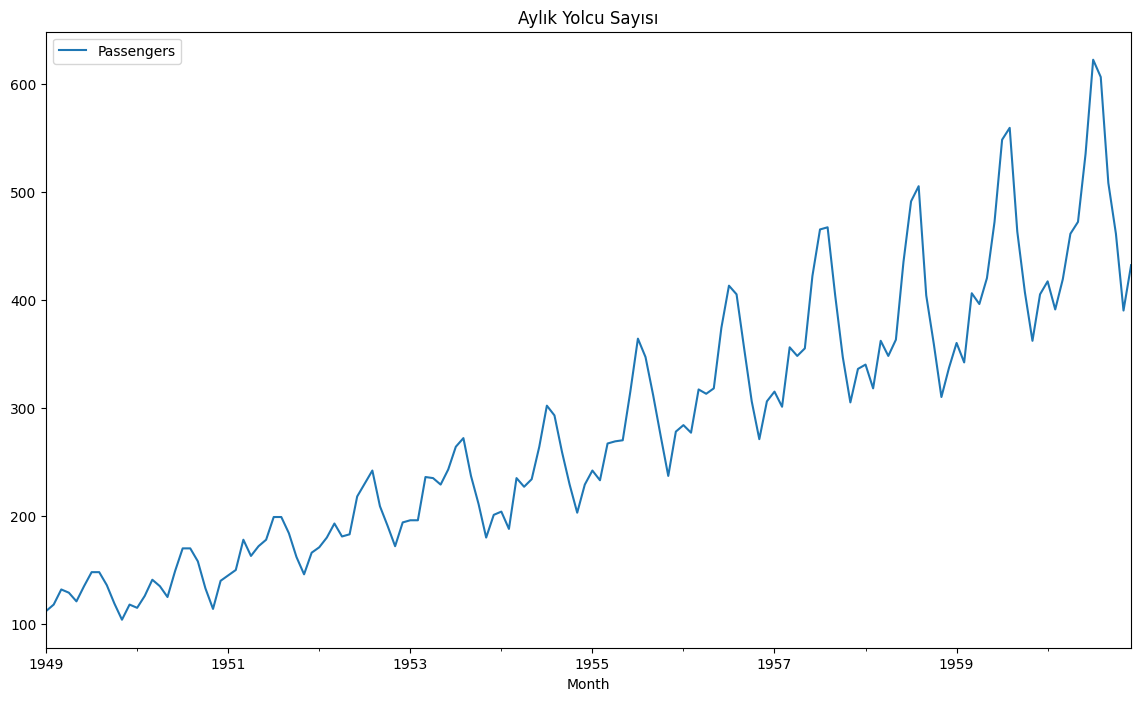

In [213]:
df.plot(figsize=(14,8), title = "Aylık Yolcu Sayısı")

In [214]:
data = df["Passengers"].values # Pandas DataFrameinden Numpy Arrayi haline getirdik

In [215]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [216]:
data = data.astype("float32")

In [217]:
type(data[0])

numpy.float32

In [218]:
data.shape

(144,)

In [219]:
data = data.reshape(-1,1)
data.shape

(144, 1)

In [220]:
def split_data(dataframe,test_size):
  position = int(round(len(dataframe) * (1-test_size))) # round fonksiyonu yukarı yuvarlamayı sağlar.
  train_data = dataframe[:position]
  test_data = dataframe[position:]
  return train_data , test_data , position

In [221]:
# %33 test %67 train olarak ayırır.
train_data , test_data , position = split_data(data,0.33)

In [222]:
train_data.shape , test_data.shape

((96, 1), (48, 1))

In [223]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [224]:
#Passengers değerlerini 0 ile 1 arasında dönüştürdük
train_data = scaler_train.fit_transform(train_data)

In [225]:
scaler_test = MinMaxScaler(feature_range = (0,1))
test_data = scaler_test.fit_transform(test_data)

In [226]:
train_data[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [228]:
# Ne kadar geriye dönük işlem yapacağını bir fonksiyon  yardımıyla tanımlıyoruz.
def create_feature(data,lookback):
  X,Y = [],[]
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X) , np.array(Y)

In [229]:
lookback = 1

In [230]:
#train veri seti
X_train , y_train = create_feature(train_data,lookback)

In [231]:
#test veri seti
X_test , y_test = create_feature(test_data,lookback)

In [232]:
#RNN methodu 3D bir görüntü istediği için reshape ile 3 boyutlu görüntü sağladık
X_train = X_train.reshape(X_train.shape[0], 1 ,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [233]:
X_train.shape , y_train.shape

((95, 1, 1), (95, 1))

#**Modelleme**

In [238]:
model = Sequential()

model.add(SimpleRNN(units = 50, activation="relu", input_shape = ([X_train.shape[1],lookback])))
model.add(Dropout(0.2)) # her iterasyonda nöron söndürülür ve Overfitting engellenir
model.add(Dense(1)) # çıkış katmanımız.

In [239]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [240]:
# Optimizasyon Metrik Ayarlanması

model.compile(optimizer = "adam", loss = "mse")

In [241]:
callbacks = [EarlyStopping(monitor = "val_loss", patience = 3,verbose = 1, mode = "min"),
             ModelCheckpoint(filepath = "best_model.h5", monitor = "val_loss",mode = "min", save_best_only = True,
                             save_weights_only = False, verbose = 1)]

In [243]:
history = model.fit(x = X_train,
                    y=y_train,
                    epochs = 50,
                    batch_size = 1,
                    validation_data = (X_test,y_test),
                    callbacks = callbacks,
                    shuffle = False)

Epoch 1/50
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 1: val_loss did not improve from 0.02072
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0037 - val_loss: 0.0209
Epoch 2/50
92/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 2: val_loss did not improve from 0.02072
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0211
Epoch 3/50
75/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 3: val_loss did not improve from 0.02072
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - val_loss: 0.0229
Epoch 4/50
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 4: val_loss did not improve from 0.02072
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0209
Epoch 5/50
81/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 5: val_loss did not improve from 0.02072
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0220
Epoch 6/50
72/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 6: 

#**Değerlendirme**

In [244]:
loss = model.evaluate(X_test,y_test,batch_size = 1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166


In [246]:
train_pre = model.predict(X_train)
test_pre = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [247]:
train_pre = scaler_train.inverse_transform(train_pre)
test_pre = scaler_train.inverse_transform(test_pre)

In [248]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_train.inverse_transform(y_test)

In [249]:
# train ve test setinin RMSE değerleri
train_rmse = np.sqrt(mean_squared_error(y_train,train_pre))
test_rmse = np.sqrt(mean_squared_error(y_test,test_pre))

In [250]:
print(f"train hatası : {train_rmse}")
print(f"test hatası : {test_rmse}")

train hatası : 24.060508744718753
test hatası : 45.109630725374906


In [251]:
train_prediction_df = result_df[lookback : position]
train_prediction_df["Predictions"] = train_pre

In [253]:
# Gerçek Değerler İle Tahmin Edilen Değerler Arasındaki Fark
train_prediction_df.head()

,Passengers,Predictions
Month,,
1949-02-01,118.0,136.162445
1949-03-01,132.0,138.261139
1949-04-01,129.0,146.988403
1949-05-01,121.0,144.931900
1949-06-01,135.0,139.774857
